In [36]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.data.loader import load_data
from src.graph.generator import swow2graph
from src.pipeline import run_ambiguity_pipeline

import re
import numpy as np
import json
import itertools
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

def pre_process(df, keep_cols=None):
    if keep_cols is None:
        keep_cols = df.columns
    df_selected = df[keep_cols].dropna().copy()

    numeric_cols = df_selected.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df_selected.select_dtypes(exclude=['number']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', StandardScaler(), numeric_cols),
            ('categorical', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
        ]
    )

    transformed_array = preprocessor.fit_transform(df_selected)

    feature_names = []
    if numeric_cols:
        feature_names.extend(numeric_cols)
    if categorical_cols:
        cat_features = preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_cols)
        feature_names.extend(cat_features)

    preprocessed_df = pd.DataFrame(transformed_array, columns=feature_names, index=df_selected.index)

    return preprocessed_df

def reg_analysis(df, language="english"):
    if language == "english":
        BASELINE = '1 + Length + LgSUBTLWF + OLD + LgSUBTLWF:Length + LgSUBTLWF:OLD'
        COVARIATES = ['Length', 'LgSUBTLWF', 'OLD']
    elif language == "spanish":
        BASELINE = '1 + log_frq + num_letters + Lev_N + log_frq:num_letters + log_frq:Lev_N'
        COVARIATES = ['log_frq', 'num_letters', 'Lev_N']

    # baseline
    baseline_formula = 'log_rt ~ ' + BASELINE
    preprocessed_df = pre_process(df, ['log_rt'] + COVARIATES)
    baseline_model = smf.ols(baseline_formula, data=preprocessed_df).fit()

    # expanded: baseline + covariate
    expanded_formula = 'log_rt ~ ' + BASELINE + ' + ' + 'ambiguity'
    preprocessed_df = pre_process(df, ['log_rt'] + COVARIATES + ['ambiguity'])
    expanded_model = smf.ols(expanded_formula, data=preprocessed_df).fit()

    lr_stat = 2 * (expanded_model.llf - baseline_model.llf)
    dof = 1 # difference between expanded and baseline model is 1 covariate
    p_value = 1 - stats.chi2.cdf(lr_stat, dof)
    delta_aic = baseline_model.aic - expanded_model.aic
    delta_bic = baseline_model.bic - expanded_model.bic
    model_summary = expanded_model.summary()
    return lr_stat, p_value, delta_aic, delta_bic, model_summary

def plot_mse_scatter(results_dict, x_min=0, x_max=100, size_scale=10, highlight=None):
    data = []
    for k, v in results_dict.items():
        sim, dom = map(float, re.findall(r"[\d.]+", k))
        data.append({
            'similarity': sim,
            'dominance': dom,
            'rmse_n': np.sqrt(v['mse_n']),
            'rmse_max_dominance': np.sqrt(v['mse_max_dominance']),
            'words_removed': v['words_removed'],
            'label': f"({sim:.1f}, {dom:.1f})"
        })
    
    df = pd.DataFrame(data)

    # filters
    df = df[(df['rmse_n'] >= x_min) & (df['rmse_n'] <= x_max)]

    # scale point sizes
    sizes = df['words_removed'] * size_scale
    if sizes.max() == 0:
        sizes += 30  # fallback if all zero

    plt.style.use('seaborn-v0_8-white')
    _, ax = plt.subplots(figsize=(7, 6))

    # scatter
    _ = ax.scatter(df[df['label']!=highlight]['rmse_n'],
                   df[df['label']!=highlight]['rmse_max_dominance'], 
                   s=df[df['label']!=highlight]['words_removed'] * size_scale, color='black', alpha=0.2, edgecolor='none')
    # highlight
    if highlight is not None:
        _ = ax.scatter(df[df['label']==highlight]['rmse_n'], df[df['label']==highlight]['rmse_max_dominance'], 
                       s=df[df['label']==highlight]['words_removed'] * size_scale, color='red', alpha=0.5)

    # labels
    for _, row in df.iterrows():
        ax.text(row['rmse_n'], row['rmse_max_dominance'], row['label'],
                fontsize=10, color='black', ha='left', va='bottom')

    ax.set_xlabel("RMSE (N)")
    ax.set_ylabel("RMSE (Dominance)")
    ax.grid(True, linestyle=':', color='lightgray')

    # legend for dot size
    handles = []
    for w in np.linspace(df['words_removed'].min(), df['words_removed'].max(), 3):
        handles.append(plt.scatter([], [], s=w * size_scale, color='black', alpha=0.2, label=f"{int(w)}"))
    
    legend1 = ax.legend(handles=handles, title="# words removed", frameon=False, fontsize=8, loc="upper right")
    ax.add_artist(legend1)
    
    # "better" arrow
    y_min, y_max = ax.get_ylim()
    ax.annotate("better",
                xy=(x_min + 0.05 * (x_max - x_min), y_min + 0.05 * (y_max - y_min)),
                xytext=(x_min + 0.1 * (x_max - x_min), y_min + 0.1 * (y_max - y_min)),
                arrowprops=dict(arrowstyle="->", color='black', lw=1),
                fontsize=10, color='black', ha='left', va='center')

    ax.set_xlim(x_min, x_max)
    plt.show()

## Exploring `sim_cutoff` & `dom_cutoff`

In [ ]:
# ENGLISH
english_data = load_data('./data/SWOW-EN.R100.20180827.csv')
graph, _ = swow2graph(english_data)
english_words = list(graph.nodes())

edom_en = pd.read_csv('./data/edom_EN.csv', index_col=0)
edom_en = edom_en.loc[edom_en.word.isin(english_words)] # ensure word in connected component
reg_en = pd.read_csv('./data/regression_data_EN.csv', index_col=0)
reg_en = reg_en.loc[reg_en.index.isin(english_words)] # ensure word in connected component

w1 = edom_en.word.tolist()
w2 = reg_en.index.tolist()

similarity_thresholds = [0.0, 0.1, 0.3, 0.5] 
dominance_thresholds = [0.1, 0.3, 0.5, 1.0]
results = {}

for st, dt in itertools.product(similarity_thresholds, dominance_thresholds):
    amb_results = run_ambiguity_pipeline(
        words = w1,
        postprocess=True,
        similarity_threshold = st,
        dominance_threshold = dt
        )
    df = pd.DataFrame(amb_results).T
    df['n'] = df['norms'].apply(len)
    df['max_dominance'] = df['norms'].apply(lambda x: 100*max(x)/sum(x))

    # edom
    compared_df = pd.merge(
        edom_en,
        df,
        right_index=True, left_on='word'
        )

    metrics = {
        'mse_n': mean_squared_error(compared_df['n_x'], compared_df['n_y']),
        'mse_max_dominance': mean_squared_error(compared_df['max_dominance_x'], compared_df['max_dominance_y']),
        'words_removed': len(w1) - compared_df.shape[0]
        }
    
    results[str((st,dt))] = metrics
    with open('./data/optimization_results_en.json', 'w') as f:
        json.dump(results, f)

In [ ]:
# SPANISH
spanish_data = load_data('./data/SWOWRP.R70.20220426.csv')
graph, _ = swow2graph(spanish_data)
spanish_words = list(graph.nodes())

edom_rp = pd.read_csv('./data/edom_RP.csv', index_col=0)
edom_rp = edom_rp.loc[edom_rp.word.isin(spanish_words)] # ensure word in connected component
reg_rp = pd.read_csv('./data/regression_data_RP.csv', index_col=0)
reg_rp = reg_rp.loc[reg_rp.index.isin(spanish_words)] # ensure word in connected component

w1 = edom_rp.word.tolist()
w2 = reg_rp.index.tolist()

similarity_thresholds = [0.0, 0.1, 0.3, 0.5] 
dominance_thresholds = [0.1, 0.3, 0.5, 1.0]
results = {}

for st, dt in itertools.product(similarity_thresholds, dominance_thresholds):
    amb_results = run_ambiguity_pipeline(
        words = w1,
        postprocess=True,
        similarity_threshold = st,
        dominance_threshold = dt
        )
    df = pd.DataFrame(amb_results).T
    df['n'] = df['norms'].apply(len)
    df['max_dominance'] = df['norms'].apply(lambda x: 100*max(x)/sum(x))

    # edom
    compared_df = pd.merge(
        edom_rp,
        df,
        right_index=True, left_on='word'
        )

    metrics = {
        'mse_n': mean_squared_error(compared_df['n_x'], compared_df['n_y']),
        'mse_max_dominance': mean_squared_error(compared_df['max_dominance_x'], compared_df['max_dominance_y']),
        'words_removed': len(w1) - compared_df.shape[0]
        }
    
    results[str((st,dt))] = metrics
    with open('./data/optimization_results_rp.json', 'w') as f:
        json.dump(results, f)

### Plots

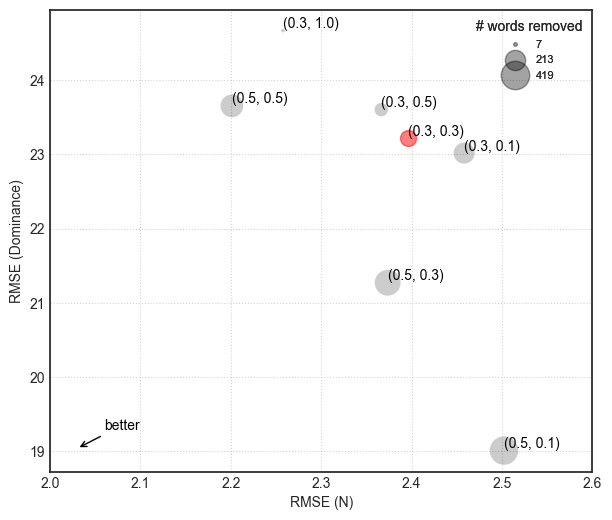

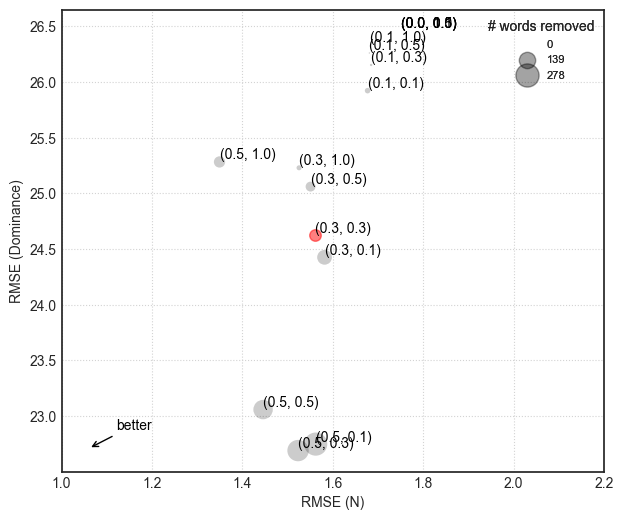

In [37]:
# optimization plots eDom
results_en = json.load(open('./data/optimization_results_en.json','r'))
plot_mse_scatter(results_en, x_min=2, x_max=2.6, size_scale=1, highlight="(0.3, 0.3)")

results_rp = json.load(open('./data/optimization_results_rp.json','r'))
plot_mse_scatter(results_rp, x_min=1, x_max=2.2, size_scale=1, highlight="(0.3, 0.3)")

## Impact on regression

In [ ]:
# ENGLISH
english_data = load_data('./data/SWOW-EN.R100.20180827.csv')
graph, _ = swow2graph(english_data)
english_words = list(graph.nodes())

edom_en = pd.read_csv('./data/edom_EN.csv', index_col=0)
edom_en = edom_en.loc[edom_en.word.isin(english_words)] # ensure word in connected component
reg_en = pd.read_csv('./data/regression_data_EN.csv', index_col=0)
reg_en = reg_en.loc[reg_en.index.isin(english_words)] # ensure word in connected component

w1 = edom_en.word.tolist()
w2 = reg_en.index.tolist()

results = {}

for p in [False, True]:
    amb_results = run_ambiguity_pipeline(
        words = list(set(w1+w2)),
        postprocess=p,
        similarity_threshold = 0.3,
        dominance_threshold = 0.3
        )
    df = pd.DataFrame(amb_results).T
    df['n'] = df['norms'].apply(len)
    df['max_dominance'] = df['norms'].apply(lambda x: 100*max(x)/sum(x))

    # reg
    reg_df = pd.merge(
        reg_en[[c for c in reg_en.columns if c != 'ambiguity']],
        df['ambiguity'].astype(float),
        right_index=True, left_on='word'
        )

    results[str(p)] = reg_df

### English

In [34]:
# ENGLISH
lr_stat, p_value, delta_aic, delta_bic, model_summary = reg_analysis(results['True'], language='english')
print(f"""
    Chi-sq test (p-value): {round(p_value,2)}
    deltaAIC: {round(-delta_aic)}
    deltaBIC: {round(-delta_bic)}
    Model summary
    {model_summary}
    """)


    Chi-sq test (p-value): 0.01
    deltaAIC: -4
    deltaBIC: 2
    Model summary
                                OLS Regression Results                            
Dep. Variable:                 log_rt   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     758.9
Date:                Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:53:35   Log-Likelihood:                -6576.3
No. Observations:                5821   AIC:                         1.317e+04
Df Residuals:                    5814   BIC:                         1.321e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [35]:
lr_stat, p_value, delta_aic, delta_bic, model_summary = reg_analysis(results['False'], language='english')
print(f"""
    Chi-sq test (p-value): {round(p_value,2)}
    deltaAIC: {round(-delta_aic)}
    deltaBIC: {round(-delta_bic)}
    Model summary
    {model_summary}
    """)


    Chi-sq test (p-value): 0.04
    deltaAIC: -2
    deltaBIC: 4
    Model summary
                                OLS Regression Results                            
Dep. Variable:                 log_rt   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     886.5
Date:                Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                        14:53:57   Log-Likelihood:                -7495.0
No. Observations:                6661   AIC:                         1.500e+04
Df Residuals:                    6654   BIC:                         1.505e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

### Spanish

In [ ]:
# SPANISH
spanish_data = load_data('./data/SWOWRP.R70.20220426.csv')
graph, _ = swow2graph(spanish_data)
spanish_words = list(graph.nodes())

edom_rp = pd.read_csv('./data/edom_RP.csv', index_col=0)
edom_rp = edom_rp.loc[edom_rp.word.isin(spanish_words)] # ensure word in connected component
reg_rp = pd.read_csv('./data/regression_data_RP.csv', index_col=0)
reg_rp = reg_rp.loc[reg_rp.index.isin(spanish_words)] # ensure word in connected component

w1 = edom_rp.word.tolist()
w2 = reg_rp.index.tolist()

results = {}

for p in [False, True]:
    amb_results = run_ambiguity_pipeline(
        words = list(set(w1+w2)),
        postprocess=p,
        similarity_threshold = 0.3,
        dominance_threshold = 0.3
        )
    df = pd.DataFrame(amb_results).T
    df['n'] = df['norms'].apply(len)
    df['max_dominance'] = df['norms'].apply(lambda x: 100*max(x)/sum(x))

    # reg
    reg_df = pd.merge(
        reg_rp[[c for c in reg_rp.columns if c != 'ambiguity']],
        df['ambiguity'].astype(float),
        right_index=True, left_on='word'
        )
    
    results[str(p)] = reg_df

In [ ]:
# SPANISH
lr_stat, p_value, delta_aic, delta_bic, model_summary = reg_analysis(results['True'], language='spanish')
print(f"""
    Chi-sq test (p-value): {round(p_value,2)}
    deltaAIC: {round(-delta_aic)}
    deltaBIC: {round(-delta_bic)}
    Model summary
    {model_summary}
    """)


    Chi-sq test (p-value): 0.11
    deltaAIC: -1
    deltaBIC: 6
    Model summary
                                OLS Regression Results                            
Dep. Variable:                 log_rt   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     682.6
Date:                Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:17:44   Log-Likelihood:                -6651.9
No. Observations:                5780   AIC:                         1.332e+04
Df Residuals:                    5773   BIC:                         1.336e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [52]:
lr_stat, p_value, delta_aic, delta_bic, model_summary = reg_analysis(results['False'], language='spanish')
print(f"""
    Chi-sq test (p-value): {round(p_value,2)}
    deltaAIC: {round(-delta_aic)}
    deltaBIC: {round(-delta_bic)}
    Model summary
    {model_summary}
    """)


    Chi-sq test (p-value): 0.01
    deltaAIC: -5
    deltaBIC: 1
    Model summary
                                OLS Regression Results                            
Dep. Variable:                 log_rt   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     754.6
Date:                Sat, 15 Nov 2025   Prob (F-statistic):               0.00
Time:                        12:17:32   Log-Likelihood:                -7259.2
No. Observations:                6320   AIC:                         1.453e+04
Df Residuals:                    6313   BIC:                         1.458e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------